In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
%pwd

In [ ]:
df1 = pd.read_csv('../../../data/round-2-island-data-bottle/prices_round_2_day_-1.csv', delimiter=';')
df2 = pd.read_csv('../../../data/round-2-island-data-bottle/prices_round_2_day_0.csv', delimiter=';')
df3 = pd.read_csv('../../../data/round-2-island-data-bottle/prices_round_2_day_1.csv', delimiter=';')
df = pd.concat([df1, df2, df3])

In [ ]:
print(df)

In [ ]:
def extract_product(df, product_name: str):
    df = df.copy()
    df_product = df[df['product'] == product_name]
    return df_product

In [ ]:
def orderbook_preprocess(df):
    """
    对订单簿数据进行预处理
    1.填充NAN为0
    2.计算best_bid, best_ask, spread, mid_price, vwap, orderbook_imbalance, ask_bid_ratio
    """

    #填充orderbook数据,nan填为0
    columns = ['ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3', 'ask_volume_3', 'bid_price_1', 'bid_volume_1', 'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3']
    for column in columns:
        df[column] = df[column].fillna(0)
    
    #计算best_bid, best_ask, spread, mid_price, vwap
    df['best_bid'] = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].min(axis=1)
    df['best_ask'] = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].max(axis=1)

    #计算best_bid, best_ask

    def get_best_bid_ask_spread(row):
    # 获取有效的买价（去掉NaN） 计算最佳买价
        bid_prices = [row['bid_price_1'], row['bid_price_2'], row['bid_price_3']]
        bid_prices = [price for price in bid_prices if price != 0]
        best_bid = min(bid_prices) if bid_prices else None

        # 获取有效的卖价（去掉NaN） 计算最佳卖价
        ask_prices = [row['ask_price_1'], row['ask_price_2'], row['ask_price_3']]
        ask_prices = [price for price in ask_prices if price != 0]
        best_ask = max(ask_prices) if ask_prices else None
        
        # 计算价差
        spread = best_ask - best_bid
        return best_bid, best_ask, spread

    df[['best_bid', 'best_ask','spread']] = df.apply(get_best_bid_ask_spread, axis=1, result_type='expand')

    #计算mid_price 
    df['mid_price'] = (df['ask_price_1']+ df['bid_price_1']) / 2

    #计算vwap
    df['vwap'] = (df['ask_price_1']*df['ask_volume_1'] + df['ask_price_2']*df['ask_volume_2'] + df['ask_price_3']*df['ask_volume_3'] + df['bid_price_1']*df['bid_volume_1'] + df['bid_price_2']*df['bid_volume_2'] + df['bid_price_3']*df['bid_volume_3']) / (df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3'] + df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3'])
    
    #计算orderbook_imbalance
    def orderbook_imbalance(row):
        """ 计算订单簿不平衡度 """
        buy_orders = [(row['bid_price_1'], row['bid_volume_1']), (row['bid_price_2'], row['bid_volume_2']), (row['bid_price_3'], row['bid_volume_3'])]
        sell_orders = [(row['ask_price_1'], row['ask_volume_1']), (row['ask_price_2'], row['ask_volume_2']), (row['ask_price_3'], row['ask_volume_3'])]
        buy_pressure = sum(amount for price, amount in buy_orders if price != 0)
        sell_pressure = sum(amount for price, amount in sell_orders if price != 0)
        total_pressure = buy_pressure + sell_pressure
        if total_pressure == 0:
            return 0
        return (buy_pressure - sell_pressure) / total_pressure
    
    df['orderbook_imbalance'] = df.apply(orderbook_imbalance, axis=1)

    #计算ask_bid_ratio
    df['ask_volume'] = df['ask_volume_1'] + df['ask_volume_2'] + df['ask_volume_3']
    df['bid_volume'] = df['bid_volume_1'] + df['bid_volume_2'] + df['bid_volume_3']
    df['ask_bid_ratio'] = (df['ask_volume'] - df['bid_volume']) / (df['ask_volume'] + df['bid_volume'])
    

    return df
    

In [7]:
product_list = df['product'].unique()
print(product_list)
product_dfs = {}
for product in product_list:
    product_df = extract_product(df, product)
    product_df.set_index('timestamp', inplace=True)
    product_dfs[product] = orderbook_preprocess(product_df)

    

In [8]:
df_croiss = product_dfs['CROISSANTS']
df_jams = product_dfs['JAMS']
df_basket1 = product_dfs['PICNIC_BASKET1']

df_djembes = product_dfs['DJEMBES']
df_basket2 = product_dfs['PICNIC_BASKET2']

In [9]:
print(df_basket1.columns)

Index(['day', 'product', 'bid_price_1', 'bid_volume_1', 'bid_price_2',
       'bid_volume_2', 'bid_price_3', 'bid_volume_3', 'ask_price_1',
       'ask_volume_1', 'ask_price_2', 'ask_volume_2', 'ask_price_3',
       'ask_volume_3', 'mid_price', 'profit_and_loss', 'best_bid', 'best_ask',
       'spread', 'vwap', 'orderbook_imbalance', 'ask_volume', 'bid_volume',
       'ask_bid_ratio'],
      dtype='object')


In [10]:
composite1 = 6*df_croiss['mid_price'] + 3*df_jams['mid_price'] + df_djembes['mid_price']
composite2 = 4*df_croiss['mid_price'] + 2*df_jams['mid_price'] 

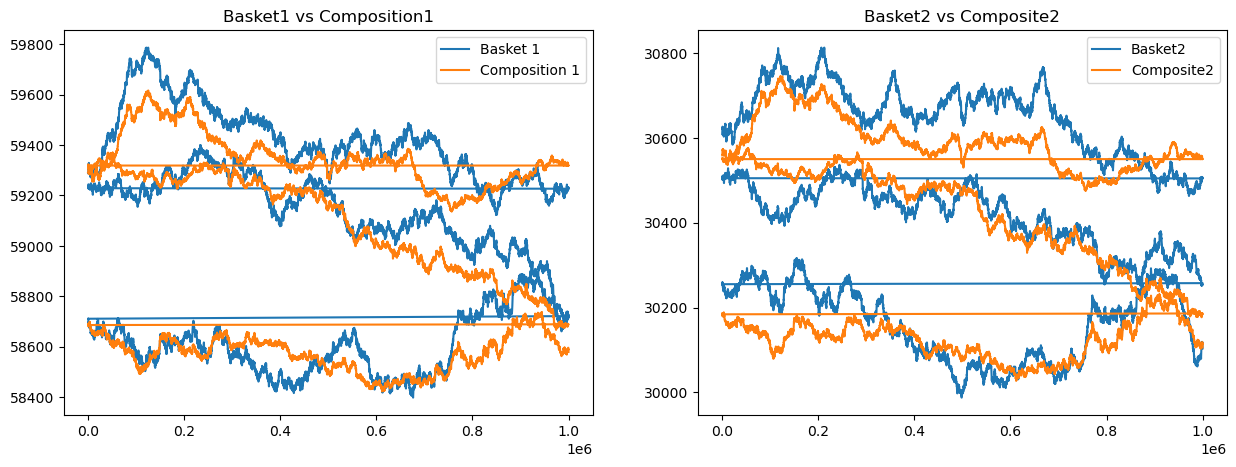

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Basket1 vs Composition1')
plt.plot(df_basket1['mid_price'], label = 'Basket 1')
plt.plot(composite1, label = 'Composition 1')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Basket2 vs Composite2')
plt.plot(df_basket2['mid_price'], label = 'Basket2')
plt.plot(composite2, label = 'Composite2')

plt.legend()
plt.show()

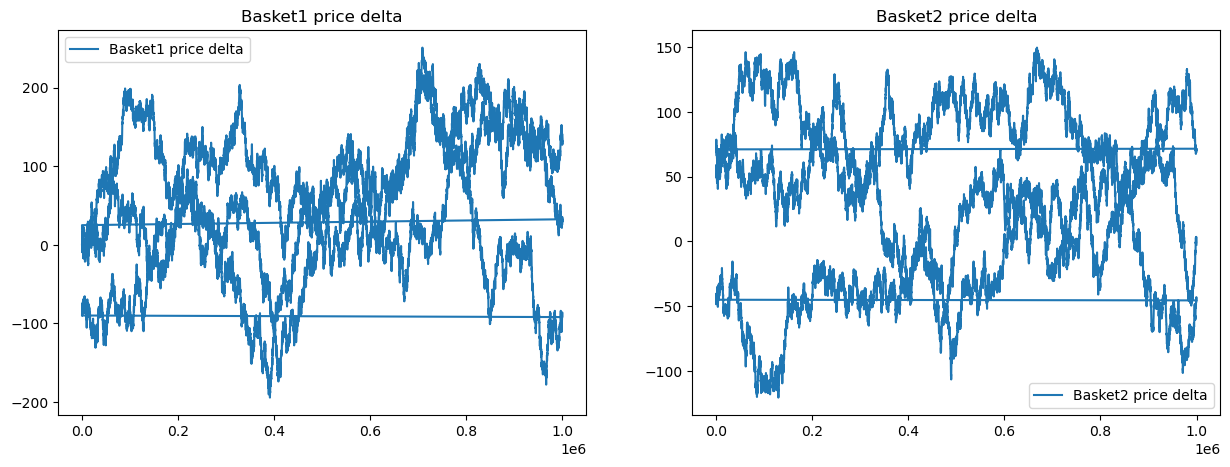

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Basket1 price delta')
plt.plot(df_basket1['mid_price'] - composite1, label = 'Basket1 price delta')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Basket2 price delta')
plt.plot(df_basket2['mid_price'] - composite2, label = 'Basket2 price delta')


plt.legend()
plt.show()

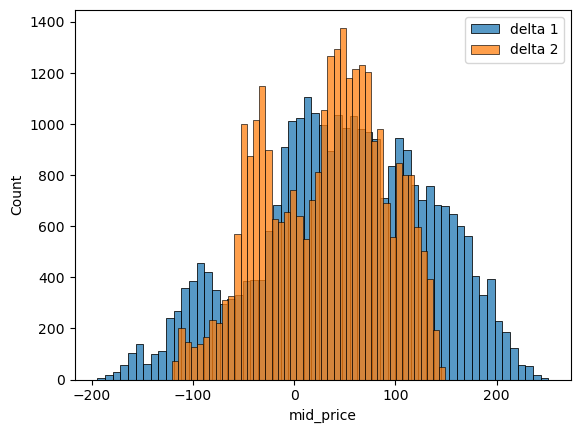

In [18]:
#画出三天delta的分布
delta1 = df_basket1['mid_price'] - composite1
delta2 = df_basket2['mid_price'] - composite2

#sns
sns.histplot(delta1, label='delta 1')
sns.histplot(delta2, label='delta 2')
plt.legend()


In [25]:
df_croiss1 = df_croiss.loc[df_croiss['day'] == -1]
df_jams1 = df_jams.loc[df_jams['day'] == -1]
df_djembes1 = df_djembes.loc[df_djembes['day'] == -1]


df_basket11 = df_basket1[df_basket1['day'] == -1]
df_basket21 = df_basket2[df_basket2['day'] == -1]

composite11 = 6*df_croiss1['mid_price'] + 3*df_jams1['mid_price'] + df_djembes1['mid_price']
composite21 = 4*df_croiss1['mid_price'] + 2*df_jams1['mid_price'] 


df_croiss2 = df_croiss.loc[df_croiss['day'] == 0]
df_jams2 = df_jams.loc[df_jams['day'] == 0]
df_djembes2 = df_djembes.loc[df_djembes['day'] == 0]

df_basket12 = df_basket1[df_basket1['day'] == 0]
df_basket22 = df_basket2[df_basket2['day'] == 0]


composite12 = 6*df_croiss2['mid_price'] + 3*df_jams2['mid_price'] + df_djembes2['mid_price']
composite22 = 4*df_croiss2['mid_price'] + 2*df_jams2['mid_price'] 


df_croiss3 = df_croiss.loc[df_croiss['day'] == 1]
df_jams3 = df_jams.loc[df_jams['day'] == 1]
df_djembes3 = df_djembes.loc[df_djembes['day'] == 1]

df_basket13 = df_basket1[df_basket1['day'] == 1]
df_basket23 = df_basket2[df_basket2['day'] == 1]


composite13 = 6*df_croiss3['mid_price'] + 3*df_jams3['mid_price'] + df_djembes3['mid_price']
composite23 = 4*df_croiss3['mid_price'] + 2*df_jams3['mid_price'] 





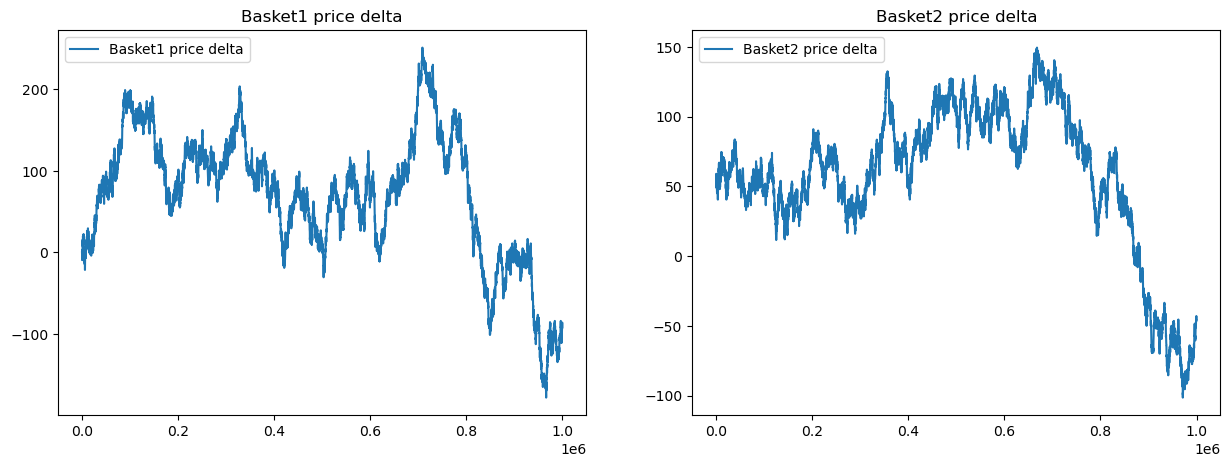

In [26]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Basket1 price delta')
plt.plot(df_basket11['mid_price'] - composite11, label = 'Basket1 price delta')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Basket2 price delta')
plt.plot(df_basket21['mid_price'] - composite21, label = 'Basket2 price delta')


plt.legend()
plt.show()

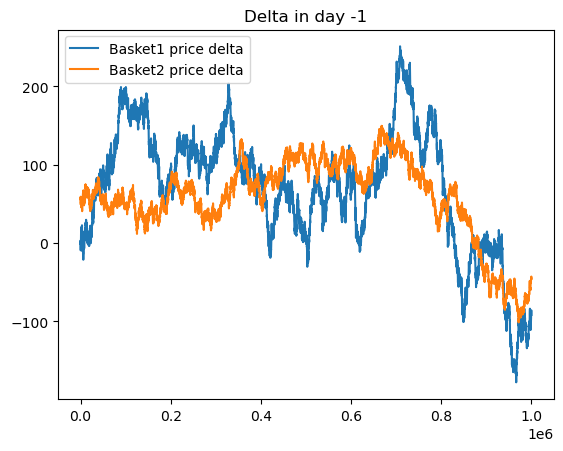

In [27]:
plt.title("Delta in day -1")
plt.plot(df_basket11['mid_price'] - composite11, label = 'Basket1 price delta')
plt.plot(df_basket21['mid_price'] - composite21, label = 'Basket2 price delta')
plt.legend()
plt.show()

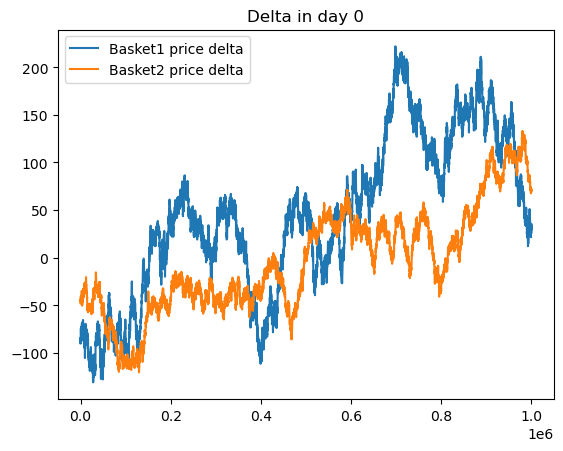

In [28]:
plt.title("Delta in day 0")
plt.plot(df_basket12['mid_price'] - composite12, label = 'Basket1 price delta')
plt.plot(df_basket22['mid_price'] - composite22, label = 'Basket2 price delta')
plt.legend()
plt.show()

In [29]:
print(df_basket13['mid_price'] - composite13)

timestamp
0          25.0
100        22.5
200        21.5
300        22.5
400        23.0
          ...  
999500    131.0
999600    132.5
999700    127.5
999800    136.5
999900    140.0
Name: mid_price, Length: 10000, dtype: float64


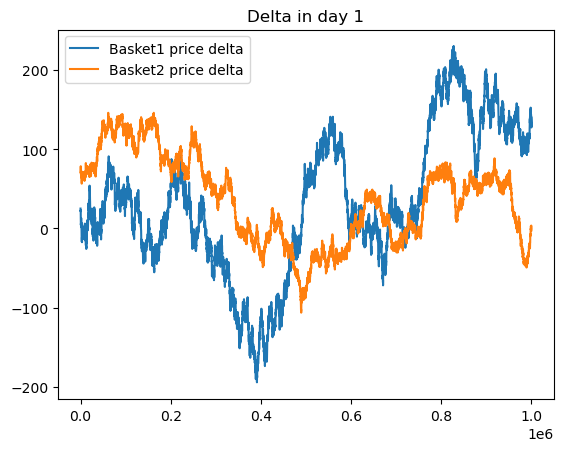

In [30]:
plt.title("Delta in day 1")
plt.plot(df_basket13['mid_price'] - composite13, label = 'Basket1 price delta')
plt.plot(df_basket23['mid_price'] - composite23, label = 'Basket2 price delta')
plt.legend()
plt.show()

In [33]:
#计算三天内所有delta的总和
delta1_sum1 = sum(abs(df_basket11['mid_price'] - composite11))
delta2_sum1 = sum(abs(df_basket21['mid_price'] - composite21))

delta1_sum2 = sum(abs(df_basket12['mid_price'] - composite12))
delta2_sum2 = sum(abs(df_basket22['mid_price'] - composite22))

delta1_sum3 = sum(abs(df_basket13['mid_price'] - composite13))
delta2_sum3 = sum(abs(df_basket23['mid_price'] - composite23))




In [34]:
print(f"Delta sum in day -1, delta1: {delta1_sum1}, delta2: {delta2_sum1}")
print(f"Delta sum in day 0, delta1: {delta1_sum2}, delta2: {delta2_sum2}")
print(f"Delta sum in day 1, delta1: {delta1_sum3}, delta2: {delta2_sum3}")


Delta sum in day -1, delta1: 899895.0, delta2: 715681.0
Delta sum in day 0, delta1: 775958.0, delta2: 464175.5
Delta sum in day 1, delta1: 742713.0, delta2: 541393.5
